In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix

In [2]:
#Subreddit column is the target of this data. 
# 1: r/CSCareerQuestions
# 2: r/PersonalFinance

df = pd.read_csv('data/clean_subreddit_data.csv')
df.head()
# Remember our target of the modeling will be "subreddit" column and
# our features will be the "selftext" column
# for subreddits: 1 represents r/CSCareerQuestions, 0 represents r/personalfinance

,title,selftext,subreddit,created_utc,post_word_count,post_length
0,Anyone graduated/currently enrolled in U Washi...,Would like to connect and clarify some doubts....,1,1637254319,10,65
1,possible implications in returning to work in ...,I've held off my cs studies for most of covid ...,1,1637254205,80,415
2,VR Career Advice,My background is in designing and programming ...,1,1637253634,468,2681
3,Professional resume writing service?,[removed],1,1637253631,1,9
4,Has being completely honest and upfront about ...,"Hello,\n\nI hate playing the game of salary ne...",1,1637253246,78,440


In [3]:
# X is features, y is target
# Note: In this classification problem we only use one column (text) for training
X = df['selftext']
y = df['subreddit']
y.value_counts(normalize=True)
# BASELINE ACCURACY FOR OUR MODEL

0    0.515014
1    0.484986
Name: subreddit, dtype: float64

In [4]:
# Training and Testing split of the data set for our model
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,stratify = y)

In [5]:
# Show the sizes of training and test sets for X and y
print(f'Training messages shape is:{X_train.shape}')
print(f'Testing messages shape is:{X_test.shape}')
print(f'Training targets shape is:{y_train.shape}')
print(f'Testing targets shape is:{y_test.shape}')



Training messages shape is:(1823,)
Testing messages shape is:(608,)
Training targets shape is:(1823,)
Testing targets shape is:(608,)


In [6]:
#Initiate Count vectorizer with english stop words
cvec = CountVectorizer(stop_words='english')
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)



In [7]:
# Cteate a data frame from the cvec matrix by applying .todense()
X_train_df = pd.DataFrame(X_train_cvec.todense(),columns = cvec.get_feature_names())
X_test_df = pd.DataFrame(X_test_cvec.todense(),columns = cvec.get_feature_names())
X_train_df['cs_or_pf'] = y_train.values
X_train_df.head()



,00,000,000k,000lbs,001,008,00s,01,02,025,...,zf5cp8u,zillow,zip,zoho,zone,zoned,zoom,zuckerberg,être,cs_or_pf
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
# Show the count of the personal finance and cs/Career Questions 
# 1 is for r/CSCareerQuestions, 0 is for r/personalfinance
X_train_df.groupby('cs_or_pf').sum().T.sort_values(0,ascending=False).head(20)

cs_or_pf,0,1
credit,582,4
money,553,70
just,517,531
year,517,308
pay,501,122
account,440,12
like,423,617
car,379,3
don,364,431
years,355,316


In [9]:
#initial pipeline framework with countvectorizer and logistic regression 
pipe = Pipeline([
    ('cvec',CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model',LogisticRegression())
])

In [10]:
params = {
    
}# Baseline parameters - RUN 1
gs = GridSearchCV(pipe,param_grid=params)
gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9632500376335994
{}


In [11]:
params2 = {
    'cvec__stop_words':['english']
}# Baseline parameters - RUN 1
gs = GridSearchCV(pipe,param_grid=params2)
gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9610537407797682
{'cvec__stop_words': 'english'}


In [12]:
preds = gs.predict(X_test)
gs.score(X_test,y_test)

0.9490131578947368

In [13]:
params3 = {
    'cvec__ngram_range': [(1,1),(1, 2),(1,3),(2,2),(3,3)], 
    'cvec__stop_words':['english'],
    'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
    'tfidf__use_idf': [True,False]
}
gs = GridSearchCV(pipe,param_grid=params3)
gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9621526418786693
{'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'model__solver': 'newton-cg', 'tfidf__use_idf': True}


In [14]:
preds = gs.predict(X_test)
gs.score(X_test,y_test)

0.9424342105263158

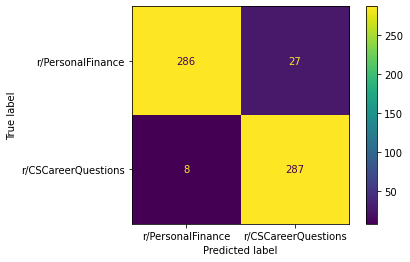

In [15]:
# Create confusion Matrix
plot_confusion_matrix(gs,X_test,y_test,display_labels = ['r/PersonalFinance','r/CSCareerQuestions']);
plt.savefig('./images/model_1_confusion_matrix')

In [16]:
pipe2 = Pipeline([
    ('cvec',CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model',KNeighborsClassifier())
])



In [17]:
params = {}
gs = GridSearchCV(pipe2,param_grid=params)
gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9221210296552762
{}


In [18]:
preds = gs.predict(X_test)
gs.score(X_test,y_test)

0.9144736842105263

In [19]:
params2 = {
    'cvec__stop_words':['english'],
    'tfidf__use_idf': [True,False]
    
}# Baseline parameters - RUN 1
gs = GridSearchCV(pipe2,param_grid=params2)
gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9369275929549902
{'cvec__stop_words': 'english', 'tfidf__use_idf': True}


In [20]:
preds = gs.predict(X_test)
gs.score(X_test,y_test)

0.9276315789473685

In [21]:
params3 = {
    'cvec__ngram_range': [(1,1),(1, 2),(1,3),(2,2),(3,3)], 
    'cvec__stop_words':['english'],
    'model__n_neighbors': list(range(1, 21, 2)), 
    'tfidf__use_idf': [True,False]
}
gs = GridSearchCV(pipe2,param_grid=params3)
gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9566716844799037
{'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english', 'model__n_neighbors': 19, 'tfidf__use_idf': True}


In [22]:
preds = gs.predict(X_test)
gs.score(X_test,y_test)


0.9391447368421053

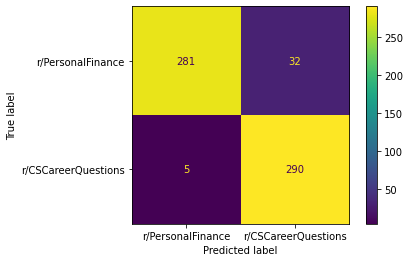

In [23]:
# Create confusion Matrix
plot_confusion_matrix(gs,X_test,y_test,display_labels = ['r/PersonalFinance','r/CSCareerQuestions']);
plt.savefig('./images/model_2_confusion_matrix')